In [6]:
import pandas as pd
import numpy as np
import tensorflow.keras as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,f1_score,accuracy_score,roc_auc_score,roc_curve
import warnings
warnings.filterwarnings('ignore')

In [7]:
x= pd.read_csv("../data/X_train.csv") 
y = pd.read_csv("../data/Y_train.csv")
x_test = pd.read_csv("../data/X_test.csv")

In [8]:
y_trial = pd.read_csv("../data/Y_train.csv")
y_trial.value_counts()

Outcome
AD         303
C           97
dtype: int64

In [9]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x = scaler.fit_transform(x)
# x_test = scaler.fit_transform(x_test)

In [10]:
y.replace({'C':0,'AD':1}, inplace = True)

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, shuffle= True, random_state=1)

### METHOD 1: ELASTIC NET CV WITH LOGIT

### Elastic net with logisticregressionCV

In [12]:
from sklearn.linear_model import LogisticRegressionCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV

### Tuning hyperparameter for Elastic net

In [4]:
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, cv=cv, n_jobs=-1)
# perform the search
results = search.fit(x_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

### Fiting the model using best parameters for elastic net

In [13]:
model_elastic = ElasticNet(alpha=0.1, l1_ratio=0.00)
# fit model_elastic
model_elastic.fit(x_train, y_train)

# make a prediction
yhat_train = model_elastic.predict(x_train)
yhat = model_elastic.predict(x_valid)
# summarize prediction


In [5]:
# elasticNet_pred_Prob = model_elastic.predict_proba(x_valid)[:,1]

In [14]:
yhat = pd.DataFrame(yhat)
yhat = round(abs(yhat))
yhat_train = pd.DataFrame(yhat_train)
yhat_train = round(abs(yhat_train))

In [15]:
print('classification_report train:',classification_report(yhat_train,y_train))
print('classification_report test:',classification_report(yhat,y_valid))

classification_report train:               precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        68
         1.0       1.00      0.96      0.98       232

    accuracy                           0.97       300
   macro avg       0.94      0.98      0.96       300
weighted avg       0.97      0.97      0.97       300

classification_report test:               precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        18
         1.0       1.00      0.98      0.99        82

    accuracy                           0.98       100
   macro avg       0.95      0.99      0.97       100
weighted avg       0.98      0.98      0.98       100



In [16]:
from sklearn.linear_model import Ridge
n_alphas = 200
clf = Ridge()
alphas = np.logspace(-6, 6, n_alphas)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(x, y)
    coefs.append(clf.coef_)

In [17]:
coefs = np.array(coefs)
coefs.shape

(200, 1, 360)

In [18]:
coefs = np.array(coefs)
coefs.shape
coefs = coefs.reshape(n_alphas,360)

(2.5118864315095823e-07,
 3981071.7055349695,
 -0.4306922529195575,
 0.7355213526182813)

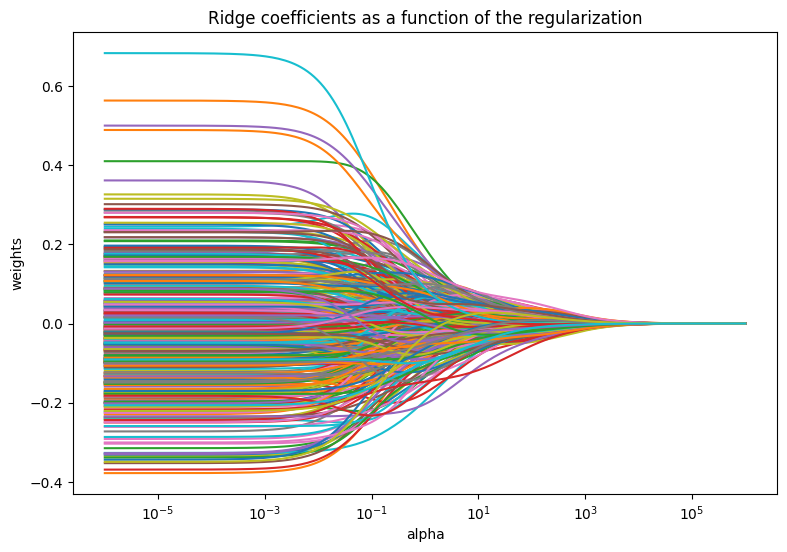

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")


In [20]:
from sklearn.linear_model import Ridge
model_ridge = Ridge().fit(x_train, y_train)
# fit model_ridge
# make a prediction
yhat_train = model_ridge.predict(x_train)
yhat = model_ridge.predict(x_valid)
# summarize prediction


In [66]:
yhat_1 = []
if yhat.any()>0.5:
    yhat_1.append(1)
else:
    yhat_1.append(0)

In [67]:
yhat_1

[1]

### METHOD 2: DIMENSIONALITY REDUCTION USING PCA,AE, THEN FIT TO LOGISTIC VS SVM 

In [69]:
dim = np.arange(30,len(x_train)+1, 10)
dim

array([ 30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150,
       160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280,
       290, 300])

In [21]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
accur = []
for i in dim:
    pca = PCA(n_components=i)
    # pca.fit_transform(x)
    x_pca_train = pca.fit_transform(x_train)
    x_pca_valid = pca.transform(x_valid)
    model_logit = LogisticRegression(solver='liblinear', random_state=0).fit(x_pca_train,y_train)
    accur.append(accuracy_score(model_logit.predict(x_pca_valid),y_valid)) 


Text(0, 0.5, 'Accuracy (Logistic Regression)')

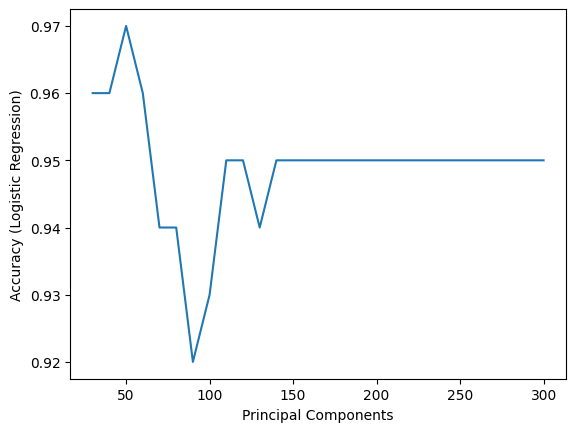

In [130]:
plt.plot(dim, accur)
plt.xlabel("Principal Components")
plt.ylabel("Accuracy (Logistic Regression)")

In [170]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
pca = PCA(n_components=57)
pca.fit_transform(x)
print(sum(pca.explained_variance_ratio_))


0.6812667190891014


In [172]:
x_pca_train = pca.fit_transform(x_train)
x_pca_valid = pca.transform(x_valid)
x_pca_test = pca.transform(x_test)
model_logit = LogisticRegression(solver='liblinear', random_state=0).fit(x_pca_train,y_train)
print('classification_report:',classification_report(model_logit.predict(x_pca_train),y_train))
print('classification_report:',classification_report(model_logit.predict(x_pca_valid),y_valid))
print('accuracy:', accuracy_score(model_logit.predict(x_pca_valid),y_valid))

classification_report:               precision    recall  f1-score   support

           0       0.88      0.97      0.93        70
           1       0.99      0.96      0.98       230

    accuracy                           0.96       300
   macro avg       0.94      0.97      0.95       300
weighted avg       0.97      0.96      0.96       300

classification_report:               precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.99      0.98      0.98        81

    accuracy                           0.97       100
   macro avg       0.94      0.96      0.95       100
weighted avg       0.97      0.97      0.97       100

accuracy: 0.97


c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
model_logit_gross = LogisticRegression(solver='liblinear', random_state=0).fit(x_train,y_train)
print('classification_report:',classification_report(model_logit_gross.predict(x_train),y_train))
print('classification_report:',classification_report(model_logit_gross.predict(x_valid),y_valid))

classification_report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       223

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

classification_report:               precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.96      0.97      0.97        79

    accuracy                           0.95       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.95      0.95      0.95       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [173]:
from sklearn import svm
pca_svc = svm.SVC()
pca_svc.fit(x_pca_train, y_train)
print('classification_report:',classification_report(y_train, pca_svc.predict(x_pca_train)))
print('classification_report:',classification_report(y_valid, pca_svc.predict(x_pca_valid)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.87      0.93        77
           1       0.96      1.00      0.98       223

    accuracy                           0.97       300
   macro avg       0.98      0.94      0.95       300
weighted avg       0.97      0.97      0.97       300

classification_report:               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.98      1.00      0.99        80

    accuracy                           0.98       100
   macro avg       0.99      0.95      0.97       100
weighted avg       0.98      0.98      0.98       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [183]:
x_pca_test.shape

(400, 57)

##### Therefore, 57 principal components would result in the best performance in relation to dimensionality reduction. Comparing logistic regression with linear support classifier, logistic regression has a test accuracy of 97% while svc has 98%

In [210]:
import random
accur_ae = []
def comp_ae(n_latent):
    random.seed(0)
    n_input = len(x_train.columns)
    n_hidden = len(x_train.columns)
    n_latent = 70
    epoch = 200
    lr = 1e-3
    encoder = Sequential([
        Dense(n_input, activation='selu', input_dim=n_input),
        # Dense(n_hidden, activation='selu'),
        Dense(n_latent, activation='selu')
    ])
    decoder = Sequential([
        # Dense(n_hidden, activation='selu'),
        Dense(n_input, activation='selu')
    ])
    stacked_ae = Sequential([encoder,decoder])
    checkpoint_cb = tf.callbacks.ModelCheckpoint("my__model.h5",save_best_only=True)
    early_stopping_cb = tf.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
    stacked_ae.compile(optimizer = tf.optimizers.Adam(learning_rate = lr), loss = tf.losses.mean_squared_error, metrics='accuracy')
    # history = stacked_ae.fit(x_train, x_train, epochs=epoch, validation_data=[X_test, X_test],callbacks=[checkpoint_cb, early_stopping_cb])
    history = stacked_ae.fit(x_train, x_train, epochs=epoch, validation_data=[x_valid, x_valid])
    train_encoded = encoder.predict(x_train)
    full_encoded = stacked_ae.predict(x_train)
    test_encoded = encoder.predict(x_valid)
    model_logit_ae = LogisticRegression(solver='liblinear', random_state=0).fit(train_encoded,y_train)
    return(accuracy_score(model_logit_ae.predict(test_encoded),y_valid))
    

In [174]:
ac1 = comp_ae(57)

Epoch 1/200
10/10 [==============================] - 2s 57ms/step - loss: 4.2421 - accuracy: 0.0000e+00 - val_loss: 2.0588 - val_accuracy: 0.0000e+00
Epoch 2/200
10/10 [==============================] - 0s 28ms/step - loss: 1.2106 - accuracy: 0.0267 - val_loss: 0.5142 - val_accuracy: 0.0800
Epoch 3/200
10/10 [==============================] - 0s 23ms/step - loss: 0.3499 - accuracy: 0.1867 - val_loss: 0.2165 - val_accuracy: 0.3200
Epoch 4/200
10/10 [==============================] - 0s 22ms/step - loss: 0.1825 - accuracy: 0.2867 - val_loss: 0.1586 - val_accuracy: 0.1700
Epoch 5/200
10/10 [==============================] - 0s 24ms/step - loss: 0.1474 - accuracy: 0.1633 - val_loss: 0.1383 - val_accuracy: 0.2200
Epoch 6/200
10/10 [==============================] - 0s 24ms/step - loss: 0.1299 - accuracy: 0.1600 - val_loss: 0.1275 - val_accuracy: 0.3200
Epoch 7/200
10/10 [==============================] - 0s 21ms/step - loss: 0.1215 - accuracy: 0.2500 - val_loss: 0.1251 - val_accuracy: 0.310

c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
# accur = []
# for i in dim:
#     pca = PCA(n_components=i)
#     # pca.fit_transform(x)
#     x_pca_train = pca.fit_transform(x_train)
#     x_pca_valid = pca.transform(x_valid)
#     model_logit = LogisticRegression(solver='liblinear', random_state=0).fit(x_pca_train,y_train)
#     accur.append(accuracy_score(model_logit.predict(x_pca_valid),y_valid)) 

In [121]:
dim = pd.DataFrame(dim)
dim.shape

(28, 1)

In [178]:
# accur_ae_


In [148]:
accur_ae_ = pd.DataFrame(accur_ae)
accur_ae_ = accur_ae_.iloc[:28]


Text(0, 0.5, 'accuracy using logistic regresion')

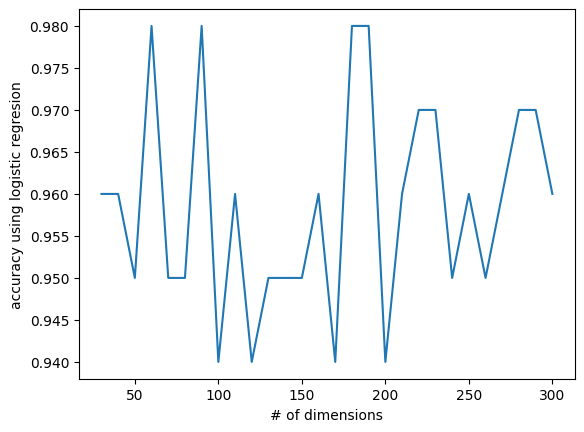

In [177]:
plt.plot(dim, accur_ae_)
plt.xlabel("# of dimensions")
plt.ylabel("accuracy using logistic regresion")

In [2]:
# [accur_ae.append(comp_ae(i)) for i in dim]
for i in dim:
    ac1 = comp_ae(i)
    accur_ae.append(ac1)


In [296]:

model_logit_ae = LogisticRegression(solver='liblinear', random_state=0).fit(train_encoded,y_train)
print('classification_report:',classification_report(model_logit_ae.predict(train_encoded),y_train))
print('classification_report:',classification_report(model_logit_ae.predict(test_encoded),y_valid))

classification_report:               precision    recall  f1-score   support

           0       0.82      0.95      0.88        66
           1       0.99      0.94      0.96       234

    accuracy                           0.94       300
   macro avg       0.90      0.95      0.92       300
weighted avg       0.95      0.94      0.94       300

classification_report:               precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.98      0.99        82

    accuracy                           0.98       100
   macro avg       0.95      0.99      0.97       100
weighted avg       0.98      0.98      0.98       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [264]:
from sklearn import svm
ae_svc = svm.SVC()
ae_svc.fit(x_pca_train, y_train)
print('classification_report:',classification_report(y_train, ae_svc.predict(x_pca_train)))
print('classification_report:',classification_report(y_valid, ae_svc.predict(x_pca_valid)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.87      0.93        77
           1       0.96      1.00      0.98       223

    accuracy                           0.97       300
   macro avg       0.98      0.94      0.95       300
weighted avg       0.97      0.97      0.97       300

classification_report:               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.98      1.00      0.99        80

    accuracy                           0.98       100
   macro avg       0.99      0.95      0.97       100
weighted avg       0.98      0.98      0.98       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [299]:
from sklearn import svm
ae_svc = svm.SVC()
ae_svc.fit(train_encoded, y_train)
print('classification_report:',classification_report(y_train, ae_svc.predict(train_encoded)))
print('classification_report:',classification_report(y_valid, ae_svc.predict(test_encoded)))

classification_report:               precision    recall  f1-score   support

           0       0.98      0.71      0.83        77
           1       0.91      1.00      0.95       223

    accuracy                           0.92       300
   macro avg       0.95      0.85      0.89       300
weighted avg       0.93      0.92      0.92       300

classification_report:               precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.92      1.00      0.96        80

    accuracy                           0.93       100
   macro avg       0.96      0.82      0.87       100
weighted avg       0.94      0.93      0.92       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [298]:
from sklearn import svm
norm_svc = svm.SVC()
norm_svc.fit(x_train, y_train)
print('classification_report:',classification_report(y_train, norm_svc.predict(x_train)))
print('classification_report:',classification_report(y_valid, norm_svc.predict(x_valid)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.84      0.92        77
           1       0.95      1.00      0.97       223

    accuracy                           0.96       300
   macro avg       0.97      0.92      0.94       300
weighted avg       0.96      0.96      0.96       300

classification_report:               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.98      1.00      0.99        80

    accuracy                           0.98       100
   macro avg       0.99      0.95      0.97       100
weighted avg       0.98      0.98      0.98       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [307]:

ae_svc_prob = svm.SVC()
ae_svc_prob.probability = True
ae_svc_prob.fit(train_encoded, y_train)
print('classification_report:',classification_report(y_train, ae_svc_prob.predict(train_encoded)))
print('classification_report:',classification_report(y_valid, ae_svc_prob.predict(test_encoded)))

classification_report:               precision    recall  f1-score   support

           0       0.98      0.71      0.83        77
           1       0.91      1.00      0.95       223

    accuracy                           0.92       300
   macro avg       0.95      0.85      0.89       300
weighted avg       0.93      0.92      0.92       300

classification_report:               precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.92      1.00      0.96        80

    accuracy                           0.93       100
   macro avg       0.96      0.82      0.87       100
weighted avg       0.94      0.93      0.92       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### METHOD 3: RF OR XGBOOST

#### Grid-search CV

from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': range (2, 7, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.05, 0.01, 0.001]
    # 'alpha':[0.01,0.1,1,10]
}


In [284]:
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': range (2, 4, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.05, 0.01, 0.001]
    # 'alpha':[0.0001,0.01,0.1,1,10]
}


In [285]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [3]:
# grid_search.fit(x_train,y_train)

In [49]:
grid_search.best_params_

{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}

In [266]:
xgb_unbalanced = XGBClassifier(n_estimators=180,max_depth=2, learning_rate=0.1, alpha = 0.1)
xgb_unbalanced.fit(x_train,y_train)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [267]:
print('classification_report:',classification_report(y_train, xgb_unbalanced.predict(x_train)))
print('classification_report:',classification_report(y_valid, xgb_unbalanced.predict(x_valid)))

classification_report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       223

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

classification_report:               precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.95      0.99      0.97        80

    accuracy                           0.95       100
   macro avg       0.95      0.89      0.92       100
weighted avg       0.95      0.95      0.95       100



### Autoencoder and PCA for XGBoost

### Autoencoder

In [286]:
grid_search.fit(train_encoded,y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [287]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}

In [300]:
xgb_unbalanced = XGBClassifier(n_estimators=180,max_depth=2, learning_rate=0.1)
xgb_unbalanced.fit(train_encoded,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [301]:
print('classification_report:',classification_report(y_train, xgb_unbalanced.predict(train_encoded)))
print('classification_report:',classification_report(y_valid, xgb_unbalanced.predict(test_encoded)))

classification_report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       223

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

classification_report:               precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.95      0.99      0.97        80

    accuracy                           0.95       100
   macro avg       0.95      0.89      0.92       100
weighted avg       0.95      0.95      0.95       100



### Random Forest (Autoencoder)

In [ ]:
# 'max_depth': range (2, 4, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.05, 0.01, 0.001]
#     # 'alpha':[0.01,0.1,1,10]

In [291]:
param_grid = {
	'n_estimators': [25, 50, 100, 150,200],
	'max_depth': range (2, 7, 1),
	'max_leaf_nodes': [3, 6, 9]
}


In [292]:
from sklearn.ensemble import RandomForestClassifier
rfc_mod = RandomForestClassifier()
grid_search = GridSearchCV(rfc_mod,
						param_grid=param_grid)
grid_search.fit(x_pca_train, y_train)
print(grid_search.best_estimator_)


c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\model_selection\_va

RandomForestClassifier(max_depth=6, max_leaf_nodes=9)


In [293]:
from sklearn.ensemble import RandomForestClassifier
rf_mod = RandomForestClassifier(max_depth=6,max_leaf_nodes=9)
rf_mod.fit(train_encoded,y_train)


C:\Users\nahomw\AppData\Local\Temp\ipykernel_22380\4260328783.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_mod.fit(train_encoded,y_train)


RandomForestClassifier(max_depth=6, max_leaf_nodes=9)

In [302]:
print('classification_report:',classification_report(y_train, rf_mod.predict(train_encoded)))
print('classification_report:',classification_report(y_valid, rf_mod.predict(test_encoded)))

classification_report:               precision    recall  f1-score   support

           0       1.00      0.78      0.88        77
           1       0.93      1.00      0.96       223

    accuracy                           0.94       300
   macro avg       0.96      0.89      0.92       300
weighted avg       0.95      0.94      0.94       300

classification_report:               precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.93      1.00      0.96        80

    accuracy                           0.94       100
   macro avg       0.97      0.85      0.89       100
weighted avg       0.94      0.94      0.94       100



### Random Forest PCA

In [278]:
from sklearn.ensemble import RandomForestClassifier
rf_mod = RandomForestClassifier(max_depth=6,max_leaf_nodes=9)
rf_mod.fit(x_pca_train,y_train)
print('classification_report:',classification_report(y_train, rf_mod.predict(x_pca_train)))
print('classification_report:',classification_report(y_valid, rf_mod.predict(x_pca_valid)))

C:\Users\nahomw\AppData\Local\Temp\ipykernel_22380\93800195.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_mod.fit(x_pca_train,y_train)


classification_report:               precision    recall  f1-score   support

           0       1.00      0.81      0.89        77
           1       0.94      1.00      0.97       223

    accuracy                           0.95       300
   macro avg       0.97      0.90      0.93       300
weighted avg       0.95      0.95      0.95       300

classification_report:               precision    recall  f1-score   support

           0       1.00      0.60      0.75        20
           1       0.91      1.00      0.95        80

    accuracy                           0.92       100
   macro avg       0.95      0.80      0.85       100
weighted avg       0.93      0.92      0.91       100



In [22]:
from sklearn.ensemble import RandomForestClassifier
rf_mod = RandomForestClassifier(max_depth=6, n_estimators=150,max_leaf_nodes=9, oob_score=True)
rf_mod.fit(x_train_pca,y_train)
# print('classification_report:',classification_report(y_train, rf_mod.predict(train_encoded)))
print('classification_report:',classification_report(y_valid, rf_mod.predict(x_test_pca)))


### METHOD 4: FEATURE SELECTION USING PCA OR VAE, THEN USING GRAPH NEURAL NET

In [184]:
x_pca_test = pca.transform(x_test)
x_pca_test.shape

(400, 57)

In [186]:
to_file = pca_svc.predict(x_pca_test)


In [ ]:
# model_logit = LogisticRegression(solver='liblinear', random_state=0).fit(x_pca_train,y_train)
# print('classification_report:',classification_report(model_logit.predict(x_pca_train),y_train))
# print('classification_report:',classification_report(model_logit.predict(x_pca_valid),y_valid))
# print('accuracy:', accuracy_score(model_logit.predict(x_pca_valid),y_valid))

In [188]:
import pandas as pd
df_prev = pd.DataFrame(to_file)
df_prev.replace({0:'C',1:'AD'}, inplace = True)

In [189]:
df_prev.to_csv('test_alz_pred_2.csv',index = False)

In [191]:
df_prev.value_counts()

AD    308
C      92
dtype: int64

In [217]:
accuracy_score(df_read,df_prev)

1.0

In [153]:
tt = model_logit.predict(x)
tt = pd.DataFrame(tt)
tt.value_counts()

ValueError: X has 360 features per sample; expecting 300

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(train_encoded, y_train)
print('classification_report:',classification_report(model_lda.predict(train_encoded),y_train))
print('classification_report:',classification_report(model_lda.predict(test_encoded),y_valid))

In [305]:
#define metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

y_pred_proba_logit = model_logit_ae.predict_proba(test_encoded)[::,1]
y_pred_proba_RF = rf_mod.predict_proba(test_encoded)[::,1]
y_pred_proba_xgb = xgb_unbalanced.predict_proba(test_encoded)[::,1]
y_pred_proba_svm = pca_svc_prob.predict_proba(test_encoded)[::,1]
y_pred_proba_lda= model_lda.predict_proba(test_encoded)[::,1]

fpr_logit, tpr_logit, _ = roc_curve(y_valid,  y_pred_proba_logit)
fpr_rf, tpr_rf, _ = roc_curve(y_valid,  y_pred_proba_RF)
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid,  y_pred_proba_xgb)
fpr_svm, tpr_svm, _ = roc_curve(y_valid,  y_pred_proba_svm)
fpr_lda, tpr_lda, _ = roc_curve(y_valid,  y_pred_proba_lda)

auc_logit = roc_auc_score(y_valid, y_pred_proba_logit)
auc_RF = roc_auc_score(y_valid, y_pred_proba_RF)
auc_xgb = roc_auc_score(y_valid, y_pred_proba_xgb)
auc_svm = roc_auc_score(y_valid, y_pred_proba_svm)
auc_lda = roc_auc_score(y_valid, y_pred_proba_lda)



NameError: name 'pca_svc_prob' is not defined

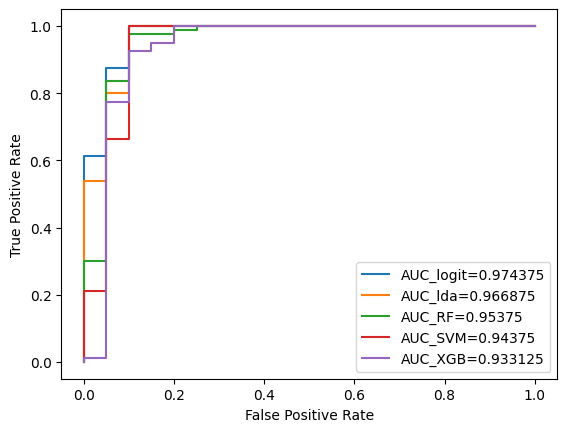

In [95]:

#create ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr_logit, tpr_logit,label="AUC_logit="+str(auc_logit))
plt.plot(fpr_lda, tpr_lda,label="AUC_lda="+str(auc_lda))
plt.plot(fpr_rf, tpr_rf,label="AUC_RF="+str(auc_RF))
plt.plot(fpr_svm, tpr_svm,label="AUC_SVM="+str(auc_svm))
plt.plot(fpr_xgb, tpr_xgb,label="AUC_XGB="+str(auc_xgb))


# plt.plot(fpr_elas, tpr_elas,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [270]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
model_qda = QuadraticDiscriminantAnalysis()
model_lda = LinearDiscriminantAnalysis()
model_lda.predict_proba
# model_qda.fit(train_encoded, y_train)
model_lda.fit(x_pca_train, y_train)
print('classification_report:',classification_report(y_valid, model_lda.predict(x_pca_valid)))


classification_report:               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.98      0.99      0.98        80

    accuracy                           0.97       100
   macro avg       0.96      0.94      0.95       100
weighted avg       0.97      0.97      0.97       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [271]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
model_qda = QuadraticDiscriminantAnalysis()
model_lda = LinearDiscriminantAnalysis()
model_lda.predict_proba
# model_qda.fit(train_encoded, y_train)
model_lda.fit(train_encoded, y_train)
print('classification_report:',classification_report(y_valid, model_lda.predict(test_encoded)))


classification_report:               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.98      0.99      0.98        80

    accuracy                           0.97       100
   macro avg       0.96      0.94      0.95       100
weighted avg       0.97      0.97      0.97       100



c:\Users\nahomw\Anaconda3\envs\alzhymer\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
